In [8]:
from pathlib import Path

import numpy as np
import pandas as pd
import jsonpickle

import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
RUNDIR = "../output"
RUNID = "20240205_222653"

In [10]:
config_files = list(Path(RUNDIR).glob(f"{RUNID}*.config.json"))
print(f"Found {len(config_files)} config files")

Found 15 config files


In [61]:
configs = {}
dfs = {}
for config_file in config_files:
    config = jsonpickle.decode(config_file.read_text())
    data_file = Path(RUNDIR, config_file.name.split(".")[0] + ".csv")
    sub_id = config_file.name.split(".")[0].split("_")[-1]
    
    data = pd.read_csv(data_file)
    data["id"] = sub_id
    data["algorithm"] = config["algorithm"]
    data["dataset"] = config["dataset"]
    data["imbalance"] = config["imbalance_type"]
    data["imbalance_val"] = config["imbalance_value"]
    data["is_last_round"] = data["round"] == (config["rounds"] - 1)
    
    if sub_id in configs:
        print("Duplicate id!")
    dfs[sub_id] = data
    configs[sub_id] = config
    
data = pd.concat(dfs.values(), axis=0)
cluster_assignments = data.query("stage == 'test' and variable == 'cluster_identities'") 
data = data.query("variable != 'cluster_identities'")
data["value"] = data["value"].astype(float)

In [42]:
data["variable"].unique()

array(['loss', 'n_samples', 'f1'], dtype=object)

In [13]:
data = data.pivot_table(values = "value", index = ["round", "client", "stage", "id", "algorithm", "dataset", "imbalance", "imbalance_val", "is_last_round"], columns = ["variable"]).reset_index()
data.head()

variable,round,client,stage,id,algorithm,dataset,imbalance,imbalance_val,is_last_round,f1,loss,n_samples
0,0,0,test,1,IFCA,cifar10,label_distribution,0.1,False,0.131613,2.239846,45.0
1,0,0,test,10,local,cifar10,label_distribution,0.1,False,0.043011,0.049458,45.0
2,0,0,test,11,IFCA,cifar10,label_distribution,10.0,False,0.050572,2.275543,482.0
3,0,0,test,12,FLSC,cifar10,label_distribution,1.0,False,0.067547,2.111070,802.0
4,0,0,test,4,local,cifar10,label_distribution,1.0,False,0.067547,0.021577,802.0


<Axes: xlabel='round', ylabel='loss'>

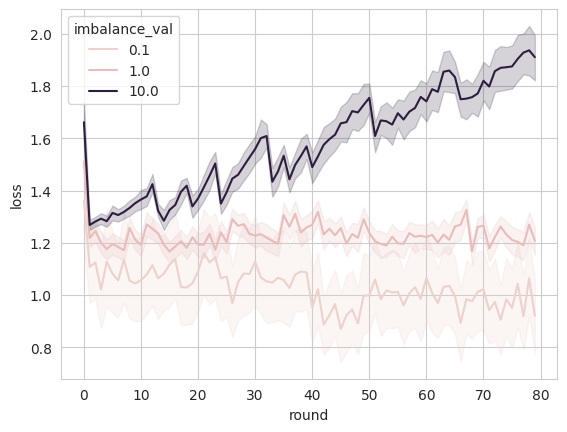

In [28]:
df = data.query("stage == 'train' and algorithm == 'IFCA'")
sns.lineplot(df, x = "round", y = "loss", hue = "imbalance_val")

<Axes: xlabel='round', ylabel='f1'>

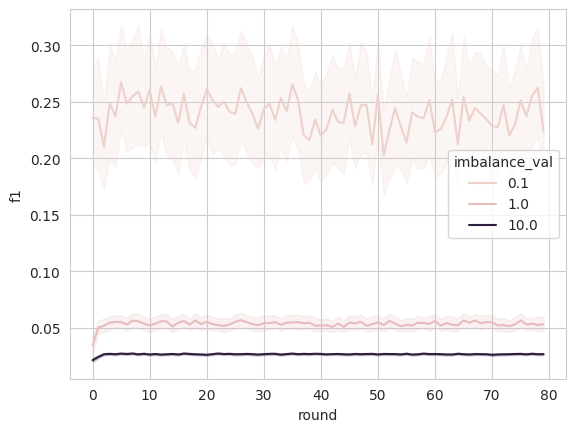

In [34]:
df = data.query("stage == 'test' and algorithm == 'FLSC'")
sns.lineplot(df, x = "round", y = "f1", hue = "imbalance_val")

In [35]:
df_last = data.query("stage == 'test' and is_last_round")
df_last

variable,round,client,stage,id,algorithm,dataset,imbalance,imbalance_val,is_last_round,f1,loss,n_samples
175034,79,0,test,10,local,cifar10,label_distribution,0.1,True,1.000000,0.000869,45.0
175035,79,0,test,11,IFCA,cifar10,label_distribution,10.0,True,0.632784,1.019030,482.0
175036,79,0,test,12,FLSC,cifar10,label_distribution,1.0,True,0.067547,2.168707,802.0
175037,79,0,test,13,FedAvg,cifar10,label_distribution,10.0,True,0.599231,1.050297,482.0
175038,79,0,test,14,FedProx,cifar10,label_distribution,10.0,True,0.731388,0.691562,482.0
...,...,...,...,...,...,...,...,...,...,...,...,...
177266,79,99,test,4,local,cifar10,label_distribution,1.0,True,0.997555,0.000443,385.0
177267,79,99,test,5,local,cifar10,label_distribution,10.0,True,0.998773,0.000357,536.0
177268,79,99,test,6,FLSC,cifar10,label_distribution,10.0,True,0.029571,2.289363,536.0
177269,79,99,test,8,FedAvg,cifar10,label_distribution,1.0,True,0.919536,0.125903,385.0


Text(0.5, 1.0, 'Avg. F1 scores by imbalance param')

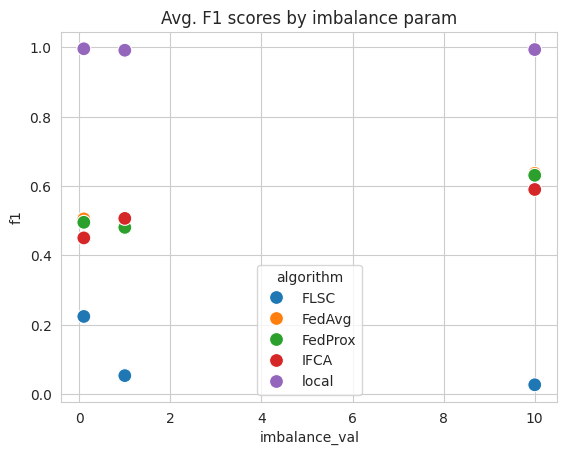

In [17]:
df_last_avg = df_last.groupby(["imbalance", "imbalance_val", "algorithm"]).mean(["f1", "loss"]).reset_index()\
    .query("imbalance == 'label_distribution'")
sns.scatterplot(df_last_avg, x="imbalance_val", y="f1", hue='algorithm', s=100)
plt.title("Avg. F1 scores by imbalance param")

In [18]:
local = df_last.query("algorithm == 'Local'")[["client","imbalance","imbalance_val","f1"]]
fedavg = df_last.query("algorithm == 'FedAvg'")[["client","imbalance","imbalance_val","f1"]]
fedprox = df_last.query("algorithm == 'FedProx'")[["client","imbalance","imbalance_val","f1"]]
ifca = df_last.query("algorithm == 'IFCA'")[["client","imbalance","imbalance_val","f1"]]
flsc = df_last.query("algorithm == 'FLSC'")[["client","imbalance","imbalance_val","f1"]]

In [19]:
f1scores = ifca.merge(flsc, on=["client", "imbalance", "imbalance_val"], suffixes=["_ifca", "_flsc"])\
    .merge(fedavg, on=["client", "imbalance", "imbalance_val"])\
    .merge(local, on=["client", "imbalance", "imbalance_val"], suffixes=["_fedavg", "_local"])\
    .merge(fedprox, on=["client", "imbalance", "imbalance_val"], suffixes=["", "_fedprox"])
f1scores = f1scores.query("imbalance == 'label_distribution'")
f1scores

variable,client,imbalance,imbalance_val,f1_ifca,f1_flsc,f1_fedavg,f1_local,f1


In [20]:
f1scores["benefit_fedavg"] = f1scores["f1_fedavg"] - f1scores["f1_local"]
f1scores["benefit_fedprox"] = f1scores["f1_fedprox"] - f1scores["f1_local"]
f1scores["benefit_ifca"] = f1scores["f1_ifca"] - f1scores["f1_local"]
f1scores["benefit_flsc"] = f1scores["f1_flsc"] - f1scores["f1_local"]

KeyError: 'f1_fedprox'

In [21]:
benefits = f1scores.drop(columns=["f1_local", "f1_fedavg", "f1_ifca", "f1_flsc"]).melt(id_vars=["client", "imbalance", "imbalance_val"], value_name="client_benefit", var_name="algorithm")

In [22]:
avg_benefits = benefits.groupby(["imbalance", "imbalance_val", "algorithm"]).mean().reset_index()

In [23]:
sns.scatterplot(avg_benefits, x="imbalance_val", y="benefit", hue="algorithm")

ValueError: Could not interpret value `benefit` for `y`. An entry with this name does not appear in `data`.

## Cluster Assignments

In [52]:
n_clusters = 5
cluster_assignments

,round,client,stage,variable,value,id,algorithm,dataset,imbalance,imbalance_val,is_last_round
5,0,0,test,cluster_identities,3.0,1,IFCA,cifar10,label_distribution,0.1,False
12,0,1,test,cluster_identities,3.0,1,IFCA,cifar10,label_distribution,0.1,False
19,0,2,test,cluster_identities,1.0,1,IFCA,cifar10,label_distribution,0.1,False
26,0,3,test,cluster_identities,4.0,1,IFCA,cifar10,label_distribution,0.1,False
33,0,4,test,cluster_identities,0.0,1,IFCA,cifar10,label_distribution,0.1,False
...,...,...,...,...,...,...,...,...,...,...,...
44770,79,94,test,cluster_identities,2|1|0|3|4,12,FLSC,cifar10,label_distribution,1.0,True
44777,79,95,test,cluster_identities,3|4|0|2|1,12,FLSC,cifar10,label_distribution,1.0,True
44784,79,96,test,cluster_identities,4|0|1|2|3,12,FLSC,cifar10,label_distribution,1.0,True
44791,79,97,test,cluster_identities,0|4|1|3|2,12,FLSC,cifar10,label_distribution,1.0,True


In [62]:
def extract_cluster_assignments(ca):
    if isinstance(ca, str):
        return list(map(int, ca.split("|")))
    else:
        return int(ca)

cluster_assignments["clusters"] = cluster_assignments["value"].apply(extract_cluster_assignments)
cluster_assignments = cluster_assignments[["round", "client", "algorithm", "imbalance", "imbalance_val", "clusters"]]

In [86]:
ca_ifca = cluster_assignments.query("algorithm == 'IFCA'")
ca_flsc = cluster_assignments.query("algorithm == 'FLSC'").explode("clusters")

In [87]:
df = ca_ifca.groupby(["round", "algorithm", "imbalance", "imbalance_val", "clusters"]).size().reset_index().rename(columns={0: 'count'})
df

,round,algorithm,imbalance,imbalance_val,clusters,count
0,0,IFCA,label_distribution,0.1,0,18
1,0,IFCA,label_distribution,0.1,1,18
2,0,IFCA,label_distribution,0.1,2,14
3,0,IFCA,label_distribution,0.1,3,15
4,0,IFCA,label_distribution,0.1,4,15
...,...,...,...,...,...,...
1195,79,IFCA,label_distribution,10.0,0,13
1196,79,IFCA,label_distribution,10.0,1,21
1197,79,IFCA,label_distribution,10.0,2,20
1198,79,IFCA,label_distribution,10.0,3,11


In [81]:
import plotly.express as px
import plotly.graph_objects as go

px.area(df.query("imbalance_val == 0.1"), x="round", y="count", color="clusters")

/home/lukas/Work/masterthesis-clustered-fl/.venv/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [85]:
px.line(ca_ifca.query("imbalance_val == 0.1"), x="round", y="clusters", color="client")

/home/lukas/Work/masterthesis-clustered-fl/.venv/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [89]:
df = ca_flsc.groupby(["round", "algorithm", "imbalance", "imbalance_val", "clusters"]).size().reset_index().rename(columns={0: 'count'})
px.area(df.query("imbalance_val == 0.1"), x="round", y="count", color="clusters")

/home/lukas/Work/masterthesis-clustered-fl/.venv/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [90]:
cluster_assignments.query("algorithm == 'FLSC'")

,round,client,algorithm,imbalance,imbalance_val,clusters
5,0,1,FLSC,label_distribution,0.1,"[1, 0, 3, 4, 2]"
12,0,2,FLSC,label_distribution,0.1,"[3, 2, 0, 2, 0]"
19,0,3,FLSC,label_distribution,0.1,"[4, 4, 1, 1, 0]"
26,0,5,FLSC,label_distribution,0.1,"[3, 1, 2, 1, 2]"
33,0,6,FLSC,label_distribution,0.1,"[3, 4, 0, 4, 0]"
...,...,...,...,...,...,...
44770,79,94,FLSC,label_distribution,1.0,"[2, 1, 0, 3, 4]"
44777,79,95,FLSC,label_distribution,1.0,"[3, 4, 0, 2, 1]"
44784,79,96,FLSC,label_distribution,1.0,"[4, 0, 1, 2, 3]"
44791,79,97,FLSC,label_distribution,1.0,"[0, 4, 1, 3, 2]"
